YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Index(['Close', 'Volume', 'Both_FVG', 'MACD_HIST', 'Target'], dtype='object', name='Price')
                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.526
Date:                Fri, 12 Dec 2025   Prob (F-statistic):             0.0388
Time:                        19:46:44   Log-Likelihood:                -13063.
No. Observations:                8272   AIC:                         2.614e+04
Df Residuals:                    8267   BIC:                         2.617e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

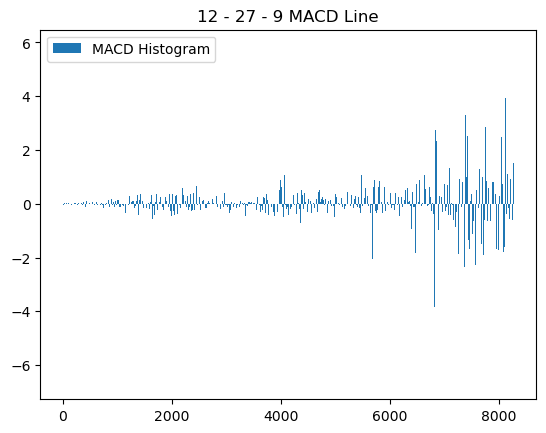

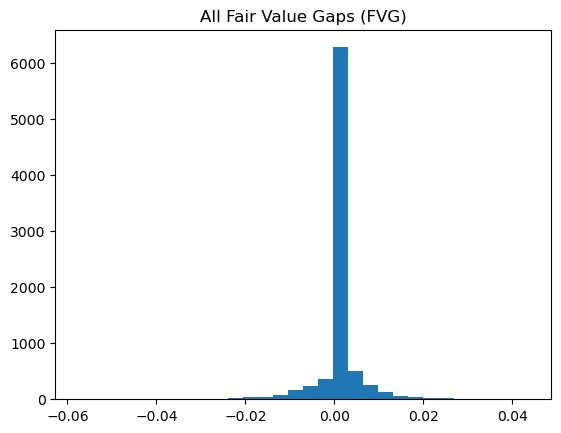

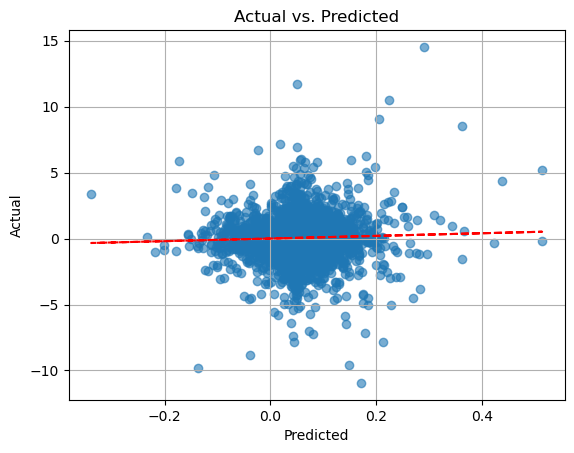


[Overall Model Significance] p-value = 0.038760


Price,Close,High,Low,Open,Volume,Target,High_2prev,Bull_FVG,Bull_FVG_Val,Low_2prev,Bear_FVG,Bear_FVG_Val,12_ema,27_ema,MACD,Signal,MACD_HIST,Both_FVG,Predictions,Residuals
0,24.313046,24.330338,24.209291,24.330338,1003200,0.711169,NaN,0,NaN,NaN,0,NaN,24.313046,24.313046,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,24.485952,24.485952,24.330321,24.330321,480500,0.211868,NaN,0,NaN,NaN,0,NaN,24.406703,24.402701,0.004002,0.002224,0.001779,NaN,NaN,NaN
2,24.537830,24.555123,24.416784,24.468661,201300,1.057094,24.330338,1,0.003523,24.209291,0,0.0,24.457882,24.451120,0.006762,0.004084,0.002678,0.003523,0.025997,1.031097
3,24.797218,24.814511,24.555126,24.572418,529400,0.418464,24.485952,1,0.002790,24.330321,0,0.0,24.564997,24.547487,0.017511,0.008632,0.008879,0.002790,0.030510,0.387954
4,24.900986,24.952863,24.607016,24.883693,531500,-0.069535,24.555123,1,0.002084,24.416784,0,0.0,24.656284,24.629033,0.027251,0.014171,0.013080,0.002084,0.034901,-0.104436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8270,685.690002,688.390015,684.580017,685.469971,79241000,-0.300427,684.909973,0,-0.000000,679.690002,0,0.0,678.627396,675.101396,3.526001,1.812817,1.713184,0.000000,0.014153,-0.314580
8271,683.630005,686.640015,681.570007,686.590027,55231500,-0.086308,685.369995,0,-0.000000,681.340027,0,0.0,679.397028,675.710582,3.686446,2.187543,1.498904,0.000000,0.020181,-0.106489
8272,683.039978,685.390015,682.590027,683.150024,58310100,0.663216,688.390015,0,-0.000000,684.580017,0,0.0,679.957482,676.234110,3.723372,2.494708,1.228664,0.000000,0.027077,0.636139
8273,687.570007,688.969971,681.309998,682.559998,85671300,0.232700,686.640015,0,-0.000000,681.570007,0,0.0,681.128640,677.043817,4.084823,2.812731,1.272091,0.000000,0.025428,0.207272


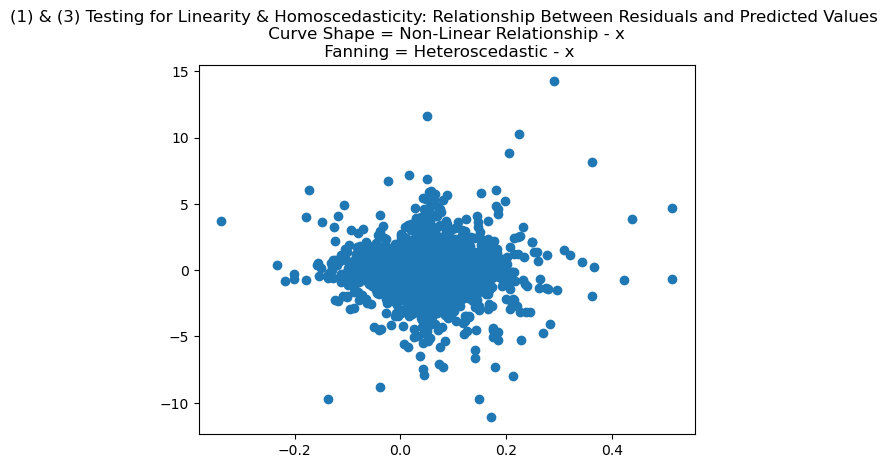

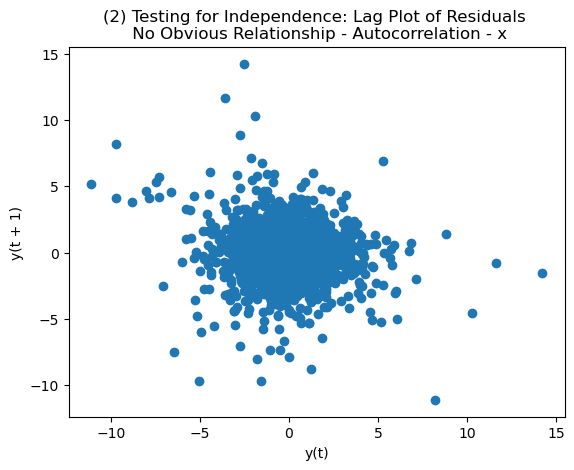

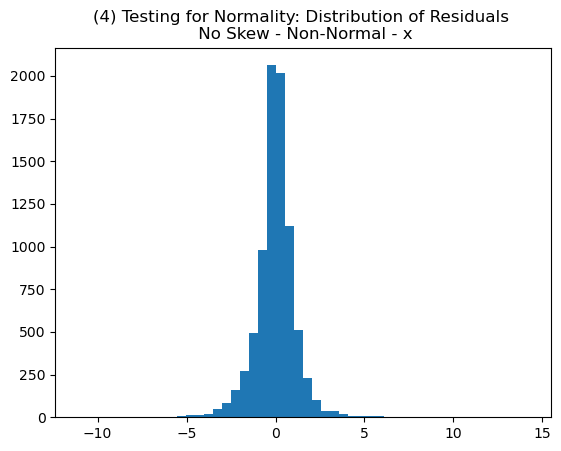

In [1]:
# Switching from SciKit Learn Lib to Stats Models Lib for cleaner results

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
    # p-Value is better acessible in this library 
import statsmodels.api as sm

# --- (0) GLOBALEN PARAMETERS ---

# Schritt 1: Ticker
TICKER = "SPY"

# Schritt 2: Preisverhalten 
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else: 
    PERIOD = "max"

# Schritt 3: Strategie/Unabhängige Variable (FGV)
STRATEGY = ["Close", "Volume", "Both_FVG", "MACD_HIST"]
# Step 3: MACD
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# Schritt 4: Verschieben von Reihen in der Vergangenheit
SHIFT = 1

# Schritt 5: Datenteilmenge (Wie viele Zeilen werden wir analysieren)
LOOKBACK = 10000

# --- (1) Daten herunterladen in df ---

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    # Step 1: Daten herunterladen
    df = yf.download(ticker, interval = interval, period = PERIOD)

    # Step 2: Nur Level 0 of Multilevel Columns selecten
    df.columns = df.columns.get_level_values(0)

    # Step 3: df for Plots vereinfachen (Index statt Datum)
    df = df.reset_index(drop=True)

    # Step 4: Nur LOOKBACK Reihen zurückgeben
    return df.iloc[-lookback:, :]

# --- (2) Abhängige Variable ("Target") definieren ---

def add_target(df, shift = SHIFT):

    # Schritt 1: Delta/Preisverhalten definieren (Morgen - Heute), in percentage Terms * 100
    df["Target"] = (df["Close"].shift(-shift) - df["Close"])/df["Close"] * 100

    # Step 2: df zurückgeben 
    return df

# --- (3) Unabhängige Variablen ("Features") definieren ---

def bull_fvg(df):
    # Schritt 1: Berechnet den Höchstpreis von vor 2 Tagen. Wird verwendet, um die Kurslücke (Gap) zu identifizieren.
    df['High_2prev'] = df['High'].shift(2)
    
    # Schritt 2:Prüft auf bullisches FVG (Fair Value Gap): Aktueller Tiefstpreis > Höchstpreis von vor 2 Tagen.
    # Wenn wahr, existiert die Lücke, und der Wert wird auf 1 gesetzt (andernfalls 0).
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    
    # Schritt 3: Berechnet die Größe des FVG, normalisiert durch den aktuellen Schlusskurs.
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    return df 

def bear_fvg(df):
    # Schritt 1: Berechnet den Tiefstpreis von vor 2 Tagen. Wird verwendet, um die Kurslücke (Gap) zu identifizieren.
    df['Low_2prev'] = df['Low'].shift(2)
    
    # Schritt 2: Prüft auf bärisches FVG (Fair Value Gap): Aktueller Höchstpreis < Tiefstpreis von vor 2 Tagen.
    # Wenn wahr, existiert die Lücke, und der Wert wird auf 1 gesetzt (andernfalls 0).
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    
    # Schritt 2: Berechnet die Größe des FVG. Der Wert wird negativ sein.
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    return df

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):

    # Step 1: Fast and Slow EMA Columns
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()

    # Step 2: MACD Column (= Difference betwenn fast and slow ema)
    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]

    # Step 3: MACD Signal (= Span Period)
    df["Signal"] = df[f"MACD"].ewm(span = span).mean()

    # Step 4: MACD Hist
    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    # Step 5: Plot Histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df["MACD_HIST"])
        # Every Bar = Every Date in the Index
        # Direction: Bar (>0) --> Bullish vs. Bar (<0) --> Bearish
        # Strength: Bar (Tall) --> Strong Momentum vs. Bar (Short) --> Weak Momentum
    plt.title(f"{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Line")
    plt.legend(["MACD Histogram"])

    return df

# --- (4) Unabhängige Variablen ("Features") definieren ---

def prepare_df_for_regression(df):
    # FVG
    # Schritt 1: wählt alle Zeilen aus, in denen entweder ein bullisches FVG oder ein bärisches FVG aufgetreten ist-
    # df = df[(df['Bull_FVG'] == 1) | (df['Bear_FVG'] == 1)].copy()
        # Ursprünglicher df hatte 10.000 Handelstage. Wenn nur an 500 Tagen ein FVG auftrat, werden 9.500 Zeilen herausgefiltert.
    
    # Schritt 2: Berechnet den kombinierten FVG-Wert: Summiert den bärischen Wert (der negativ ist) 
    # und den bullischen Wert (der positiv ist). Dies ergibt den Netto-FVG-Wert.
    df['Both_FVG'] = df['Bear_FVG_Val'] + df['Bull_FVG_Val']

    # Schritt 3: Visualisiert die Verteilung aller aufgetretenen FVG-Werte.
    plt.figure()
    plt.hist(df['Both_FVG'], bins=30)
    plt.title('All Fair Value Gaps (FVG)')
    
    return df

def generate_regression_output(df, features=STRATEGY, target="Target"):
    # Step 1: Subset Data. Wählt die Feature- und Target-Spalte aus und entfernt alle Zeilen mit fehlenden Werten (NaN).
    subset = df[features + [target]].dropna()
    print(subset.columns) # Should include all from STRATEGY + target

    # Step 2: Reshape Data and Extract Variables
    # X wird als DataFrame extrahiert, y als Series.
    X = subset[features] 
    y = subset[target] 

    # Step 3: Model Setup (Statsmodels)
    # Fügt eine Konstante (Intercept) zur X-Variable hinzu, da OLS dies separat benötigt.
    X_with_const = sm.add_constant(X)
    
    # Definiert das OLS-Modell (Ordinary Least Squares) und führt die Regression durch (.fit()).
    model = sm.OLS(y, X_with_const).fit() 

    # Step 4: Extract Results
    # Extrahieren des Intercepts (Konstante)
    intercept = model.params['const']
    # Extrahieren der Koeffizienten-Serie (ohne den Intercept)
    coefficients = model.params.drop('const')
    # Extrahieren des R-Squared Wertes
    r2 = model.rsquared
    # Extrahieren der P-Werte (ohne den Intercept)
    p_values = model.pvalues.drop('const')
    # Extrahieren des P-Wertes für das gesamte Modell
    model_p_value = model.f_pvalue # overall model significance
    # Zählt die Beobachtungen
    n_obs = len(subset)
    
    # Generiert die vorhergesagten Werte (Y-Predicted) mit der gelernten Formel.
    y_pred = model.predict(X_with_const) 

    # --- Console summary
    print(model.summary())
    
    # Plot actual vs predicted
    plt.figure()
    # Scatter Plot: Predicted Values (x) vs. Actual Values (y)
    plt.scatter(y_pred, y, alpha=0.6)
    # Zeichnet die ideale 45-Grad-Regressionslinie (y=x) zur visuellen Überprüfung
    plt.plot(y_pred, y_pred, color='red', linestyle='--')
    
    # Beschriftung und Titel
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Actual vs. Predicted")
    plt.grid(True)
    plt.show() # Fügen Sie plt.show hinzu, um die Grafik anzuzeigen

    # Gibt den unveränderten DataFrame (df) und die wichtigsten Ergebnisse zurück.
    return df, intercept, coefficients, model_p_value

# --- (5) VALIDIERUNG DES REGRESSIONSMODELLS ---

def validate_regression_output(df, coef, intercept):
    # Berechnung der Vorhersage und des Fehlers (Residuals)
    df["Predictions"] = intercept
    for feature in coef.index:
        df['Predictions'] += df[feature] * coef[feature] 

    df['Residuals'] = df["Target"] - df["Predictions"]
    # Positive Residuen bedeuten, dass das Modell zu pessimistisch war (zu niedrig vorhergesagt hat).

    # Plot 1: Linearität & Homoskedastizität (Voraussetzung für die Regression)
    # Scatter Plot: Predicted Values vs. Residuals (Fehler).
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    # Curve Shape = Non-Linear Relationship (x) | Fanning = Heteroscedastic (x)
    plt.title('(1) & (3) Testing for Linearity & Homoscedasticity: Relationship Between Residuals and Predicted Values \n Curve Shape = Non-Linear Relationship - x \n Fanning = Heteroscedastic - x')
    
    # Plot 2: Autokorrelation (Unabhängigkeit der Fehler)
    # Lag Plot: Fehler heute vs. Fehler gestern. Sollte keine offensichtliche Struktur zeigen.
    plt.figure()
    lag_plot(df['Residuals'].dropna()) 
    plt.title('(2) Testing for Independence: Lag Plot of Residuals \n No Obvious Relationship - Autocorrelation - x')

    # Plot 3: Normalität der Residuals (Glockenkurvenform)
    # Histogram: Zeigt die Verteilung der Fehler. Sollte annähernd normalverteilt sein.
    plt.figure()
    plt.hist(df['Residuals'], bins=50)
    plt.title('(4) Testing for Normality: Distribution of Residuals \n No Skew - Non-Normal - x') 

    return df

# --- HAUPT-EXECUTION (MAIN) ---

def main():
    # Annahme: Diese Schritte laden und bereiten die Daten vor
    df = get_data()
    df = add_target(df) 
    df = bull_fvg(df) 
    df = bear_fvg(df)
    df = add_MACD(df)
    df = prepare_df_for_regression(df)
    # Regression durchführen und Ergebnisse zuweisen
    # Annahme: generate_regression_output gibt df, intercept und coefficient zurück.
    df, fit_intercept, fit_coefficient, model_pval = generate_regression_output(df) 
    # 1. Statistische Validierung der Regression (visuell)
    df = validate_regression_output(df, coef=fit_coefficient, intercept=fit_intercept) 
    
    print(f"\n[Overall Model Significance] p-value = {model_pval:.6f}")

    return df

df = main()
df

In [2]:
# Trying to debug this issue 
print(yf.__version__)

0.2.57
